# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0201/npy/'
test_path='/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/test_data_indices_0203/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 19.60it/s]


Now all merge samples are saved!


In [79]:
# get all npy files
## The ratio can also be changed


t_dir_samples = test_path + "/*.npy"
te_samples = glob.glob(t_dir_samples)

# merge them
test_samples = np.load(te_samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(te_samples[1:])):
    try:
        test_samples = np.concatenate(
            (test_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(test_samples,)


# define the train/valid path
test_samples_merge_path = test_path + "test_merge.npy"

np.save(test_samples_merge_path, test_samples)

print("Now all merge samples are saved!")


4it [00:00, 41.08it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [80]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)
test_merge = np.load(test_samples_merge_path,allow_pickle=True)
print (np.array(test_merge).shape)

(1728, 1, 2)
(433, 1, 2)
(495, 1, 2)


In [81]:
kernel=24
bands=45
input_size=( kernel*kernel,bands)
output_size = 5
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)



Post-processed S2_train data shape:  (1728, 25920)


In [82]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)
X_val_rf = np.reshape(X_val, (number_samples, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (433, 25920)


In [83]:

number_samples = test_merge.shape[0]
data_test = test_merge[:,:,0]
X_test= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_test[i,:] = data_test[i,0]

Y_test = np.reshape(test_merge[:,:,1],number_samples).astype(int)
X_test_rf = np.reshape(X_test, (number_samples, kernel*kernel*bands))

print("Post-processed S2_val data shape: ", X_test_rf.shape,X_test.shape)

Post-processed S2_val data shape:  (495, 25920) (495, 24, 24, 45)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

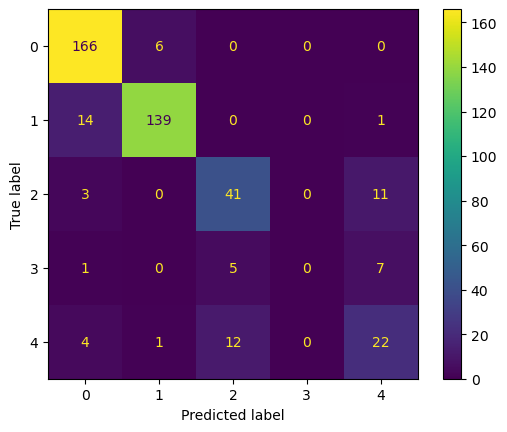

Accuracy Random Forest Classifier:  0.8498845265588915


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [11]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (1728, 576, 45)


In [15]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_val data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (433, 576, 45)


In [84]:
number_samples = X_test.shape[0]
X_test_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_test_nn[i,:] = np.reshape(X_test[i,:], (  kernel*kernel,bands))
    X_test_nn[i,:]= np.array(pd.DataFrame(X_test_nn[i,:]).fillna(0))
print("Post-processed S2_test data shape: ", X_test_nn.shape)

Post-processed S2_test data shape:  (495, 576, 45)


In [16]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=(  kernel*kernel,bands,3), pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 22:52:38.516046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 22:52:38.517714: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [98]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping3=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)

In [54]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
history = simple_model.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/100


2023-02-03 23:02:09.305258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 17ms/sample - loss: 3.2611 - accuracy: 0.4178 - val_loss: 0.8732 - val_accuracy: 0.6443


2023-02-03 23:02:09.952519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 21/100
54/54 [==============================] - 1s 10ms/sample - loss: 0.7772 - accuracy: 0.6817 - val_loss: 0.6959 - val_accuracy: 0.7460


In [56]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

14/14 [==============================] - 0s 6ms/step
Prediction example:  [8.6952072e-01 1.3034248e-01 5.2545406e-06 1.1543215e-06 1.3040997e-04]  Class:  0


2023-02-03 23:02:31.198389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


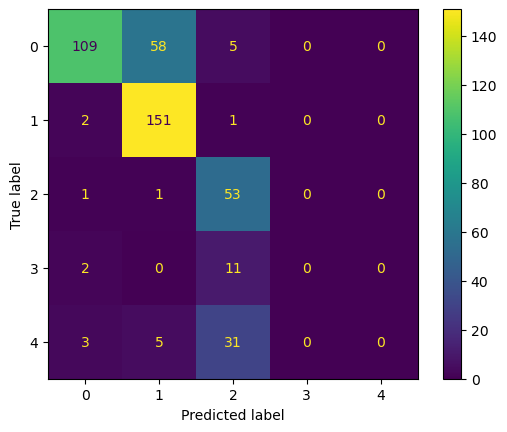

Accuracy Simple Deep Learning model:  0.7228637413394919


In [57]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

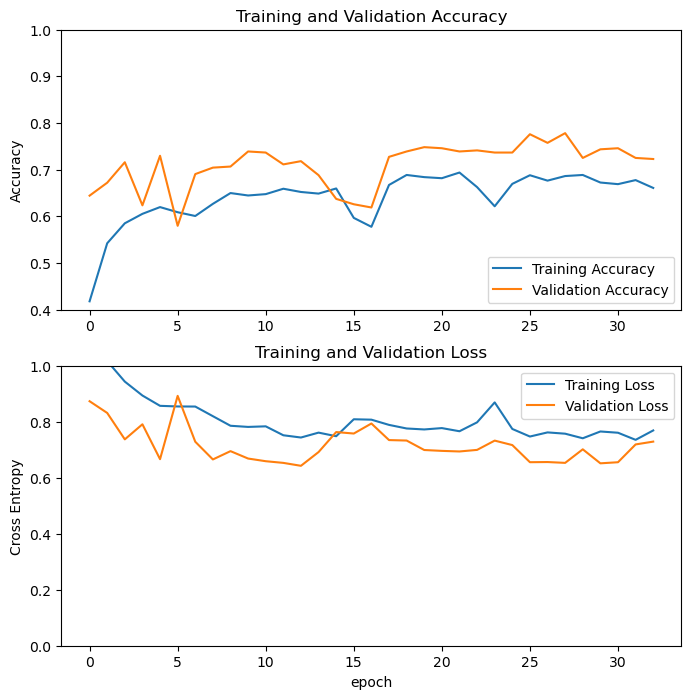

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 25920)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               3317888   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 3,318,533
Trainable params: 3,318,533
Non-trainable params: 0
_________________________________________________________________


4

In [60]:
fine_tune_epochs = 10
initial_epochs = max(history.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,callbacks=[EarlyStopping2],
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 33/150


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-03 23:02:41.516448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 16ms/step - loss: 0.7083 - accuracy: 0.6991 - val_loss: 0.6365 - val_accuracy: 0.7714
Epoch 34/150
 1/54 [..............................] - ETA: 0s - loss: 0.7121 - accuracy: 0.6250

2023-02-03 23:02:42.354221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 13ms/step - loss: 0.6992 - accuracy: 0.6962 - val_loss: 0.6373 - val_accuracy: 0.7691
Epoch 35/150
54/54 [==============================] - 1s 13ms/step - loss: 0.6955 - accuracy: 0.7049 - val_loss: 0.6328 - val_accuracy: 0.7691
Epoch 36/150
54/54 [==============================] - 1s 13ms/step - loss: 0.6874 - accuracy: 0.7043 - val_loss: 0.6365 - val_accuracy: 0.7667
Epoch 37/150
54/54 [==============================] - 1s 12ms/step - loss: 0.6922 - accuracy: 0.7124 - val_loss: 0.6419 - val_accuracy: 0.7667
Epoch 38/150
54/54 [==============================] - 1s 13ms/step - loss: 0.6894 - accuracy: 0.7060 - val_loss: 0.6333 - val_accuracy: 0.7691
Epoch 39/150
54/54 [==============================] - 1s 12ms/step - loss: 0.6992 - accuracy: 0.6956 - val_loss: 0.6326 - val_accuracy: 0.7691
Epoch 40/150
54/54 [==============================] - 1s 14ms/step - loss: 0.6847 - accuracy: 0.7037 - val_loss: 0.6358 - val_accuracy: 0.7691
Epoch 41/150

In [61]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

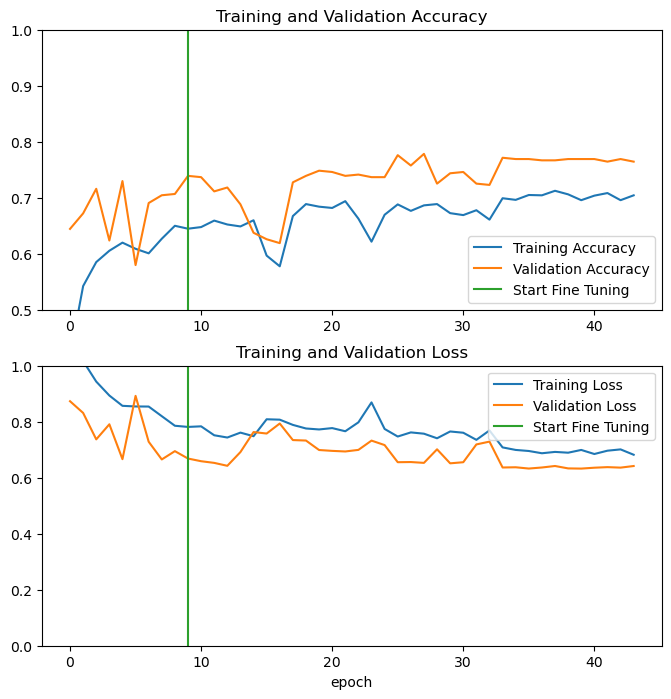

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 0s 9ms/step - loss: 0.6418 - accuracy: 0.7644
Test accuracy : 0.7644341588020325


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [64]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
    
]
)

In [65]:

CNNs_model.summary() 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 5, 128)      

In [66]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [67]:

CNNs_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 72, 5, 128)      

In [68]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn, Y_train, epochs=30,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping2],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/30


2023-02-03 23:03:24.296752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:03:28.283527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 5s 87ms/sample - loss: 1.3277 - accuracy: 0.4138 - val_loss: 0.9134 - val_accuracy: 0.6120
Epoch 11/30
54/54 [==============================] - 3s 52ms/sample - loss: 0.4787 - accuracy: 0.8166 - val_loss: 0.4901 - val_accuracy: 0.8199


In [69]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 6/14 [===========>..................] - ETA: 0s

2023-02-03 23:04:17.902062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 23ms/step
Prediction example:  [ 5.311223   1.0656947 -4.128376  -3.780608  -3.352159 ]  Class:  0


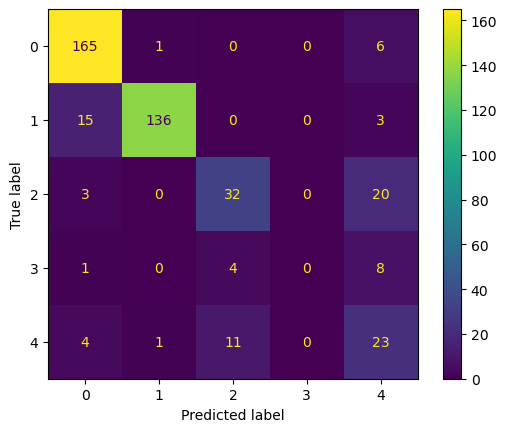

Accuracy Simple Deep Learning model:  0.8221709006928406


In [70]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

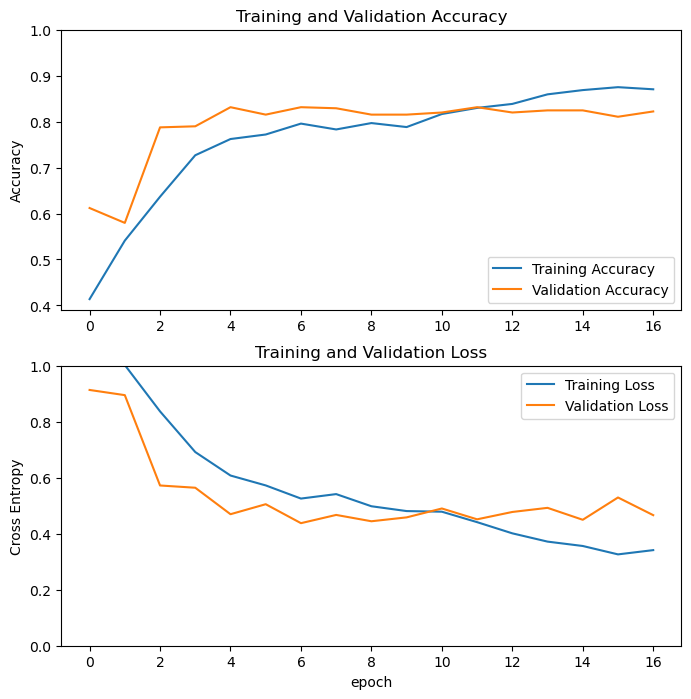

In [71]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 576, 45, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 288, 22, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 22, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 144, 11, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 11, 128)      8320      
                                                                 
 max_pooling2

14

In [73]:

fine_tune_epochs = 10
initial_epochs = max(history2.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 17/35


2023-02-03 23:04:53.011875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/54 [============================>.] - ETA: 0s - loss: 0.3205 - accuracy: 0.8827

2023-02-03 23:04:56.653213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 64ms/step - loss: 0.3219 - accuracy: 0.8819 - val_loss: 0.4503 - val_accuracy: 0.8360
Epoch 18/35
54/54 [==============================] - 3s 55ms/step - loss: 0.2843 - accuracy: 0.9016 - val_loss: 0.4530 - val_accuracy: 0.8337
Epoch 19/35
54/54 [==============================] - 3s 55ms/step - loss: 0.2676 - accuracy: 0.9057 - val_loss: 0.4563 - val_accuracy: 0.8314
Epoch 20/35
54/54 [==============================] - 3s 56ms/step - loss: 0.2667 - accuracy: 0.9045 - val_loss: 0.4572 - val_accuracy: 0.8383
Epoch 21/35
54/54 [==============================] - 3s 55ms/step - loss: 0.2629 - accuracy: 0.9045 - val_loss: 0.4595 - val_accuracy: 0.8406
Epoch 22/35
54/54 [==============================] - 3s 55ms/step - loss: 0.2558 - accuracy: 0.9126 - val_loss: 0.4604 - val_accuracy: 0.8337
Epoch 23/35
54/54 [==============================] - 3s 57ms/step - loss: 0.2514 - accuracy: 0.9149 - val_loss: 0.4626 - val_accuracy: 0.8360
Epoch 24/35
54/54 

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

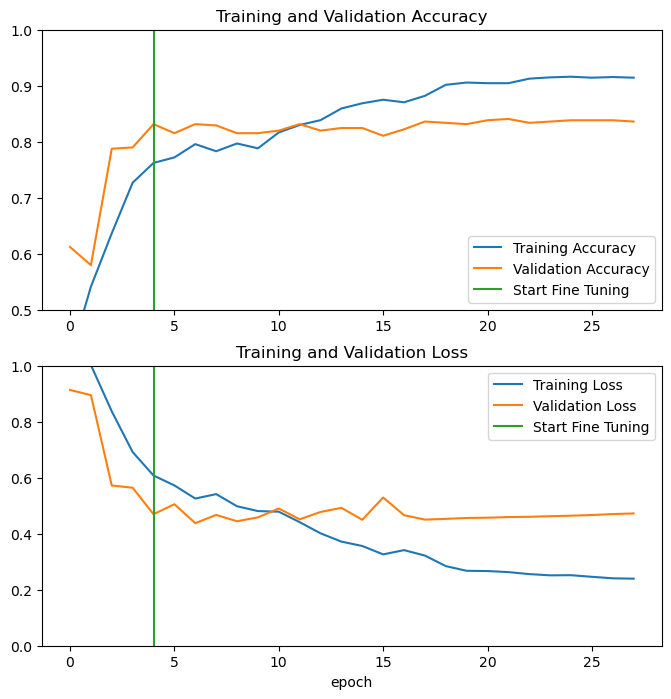

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
loss, accuracy = CNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 0s 29ms/step - loss: 0.4725 - accuracy: 0.8360
Test accuracy : 0.8360276818275452


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [77]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(  kernel*kernel,bands,1), 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [78]:
history3=model_rn.fit(X_train_nn, Y_train, epochs=80,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(X_val_nn, Y_val))


Epoch 1/80


2023-02-03 23:06:03.636490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:06:30.207951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 31s 573ms/sample - loss: 1.4688 - accuracy: 0.6007 - val_loss: 1.5762 - val_accuracy: 0.3557
Epoch 21/80
54/54 [==============================] - 22s 408ms/sample - loss: 0.4916 - accuracy: 0.8079 - val_loss: 1.0176 - val_accuracy: 0.6097
Epoch 41/80
54/54 [==============================] - 21s 387ms/sample - loss: 0.4150 - accuracy: 0.8414 - val_loss: 1.3716 - val_accuracy: 0.5635


14/14 [==============================] - 2s 148ms/step


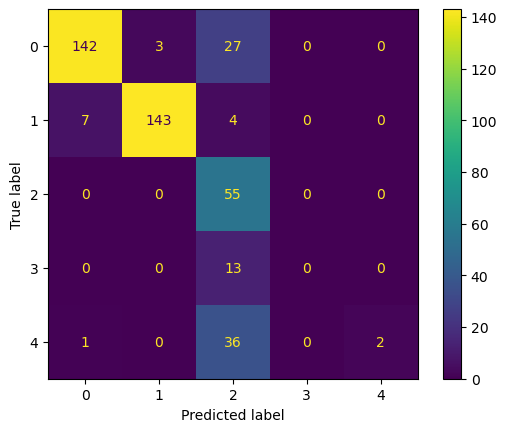

Accuracy ResNet-50 model:  0.789838337182448


In [90]:
y_pred_rn_p = model_rn.predict(X_val_nn)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

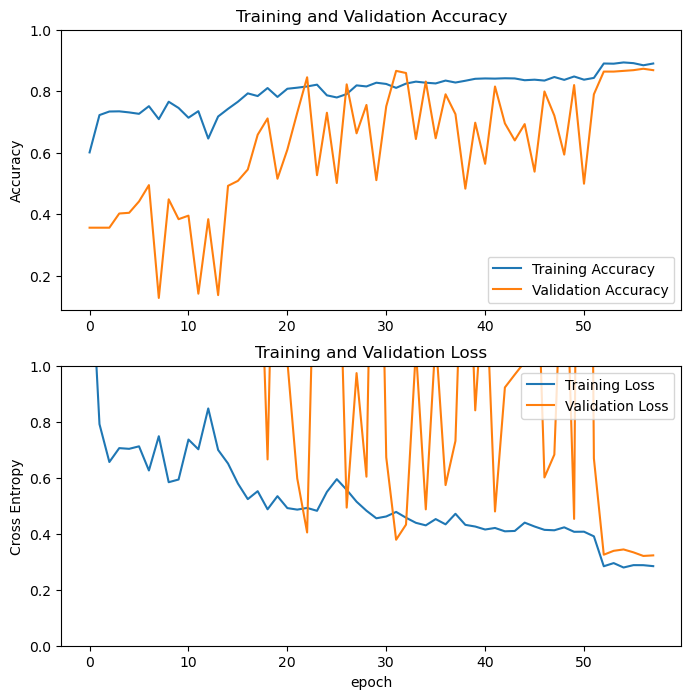

In [147]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [92]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 576, 45, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 582, 51, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 288, 23, 64)  3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 288, 23, 64

214

In [145]:
fine_tune_epochs = 10
initial_epochs = max(history3.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(X_train_nn,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping3,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 52/61
54/54 [==============================] - 25s 406ms/step - loss: 0.2732 - accuracy: 0.8941 - val_loss: 0.3346 - val_accuracy: 0.8637
Epoch 53/61
54/54 [==============================] - 22s 407ms/step - loss: 0.2886 - accuracy: 0.8906 - val_loss: 0.3343 - val_accuracy: 0.8661
Epoch 54/61
54/54 [==============================] - 22s 402ms/step - loss: 0.2905 - accuracy: 0.8929 - val_loss: 0.3183 - val_accuracy: 0.8707
Epoch 55/61
54/54 [==============================] - 23s 419ms/step - loss: 0.2757 - accuracy: 0.8906 - val_loss: 0.3187 - val_accuracy: 0.8707
Epoch 56/61
54/54 [==============================] - 23s 419ms/step - loss: 0.2688 - accuracy: 0.8976 - val_loss: 0.3324 - val_accuracy: 0.8707
Epoch 57/61
54/54 [==============================] - 23s 419ms/step - loss: 0.2791 - accuracy: 0.8935 - val_loss: 0.3376 - val_accuracy: 0.8661


In [148]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

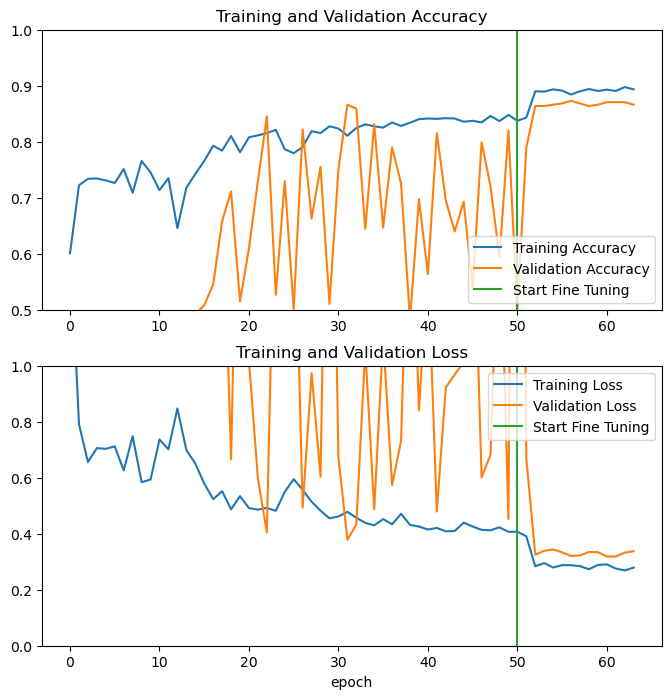

In [149]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [133]:
loss, accuracy = model_rn.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 2s 124ms/step - loss: 0.3227 - accuracy: 0.8684
Test accuracy : 0.8683602809906006


# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [102]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = bands

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [103]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-02-03 23:49:43.514911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:49:43.702363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:49:45.739060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:49:54.561574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:49:54.688717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 15s 565ms/sample - loss: 1.4383 - accuracy: 0.4531 - val_loss: 1.5332 - val_accuracy: 0.4734
Epoch 21/100
27/27 [==============================] - 5s 187ms/sample - loss: 0.7538 - accuracy: 0.7170 - val_loss: 1.2408 - val_accuracy: 0.5104


In [104]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-02-03 23:55:17.257274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 23:55:17.387674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 194ms/step
Prediction example:  [-4.0115643 -9.877487   7.2534127 -1.4572039 -2.659133 ]  Class:  2


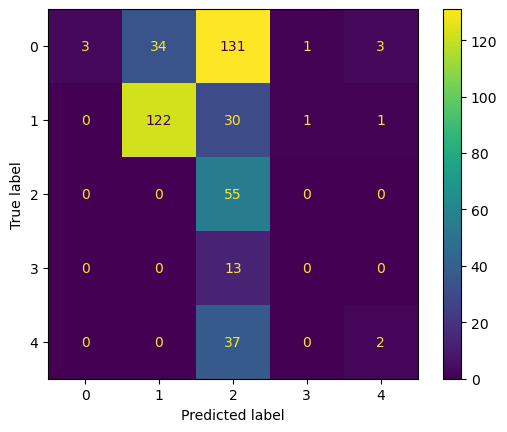

Accuracy Simple Deep Learning model:  0.42032332563510394


In [105]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

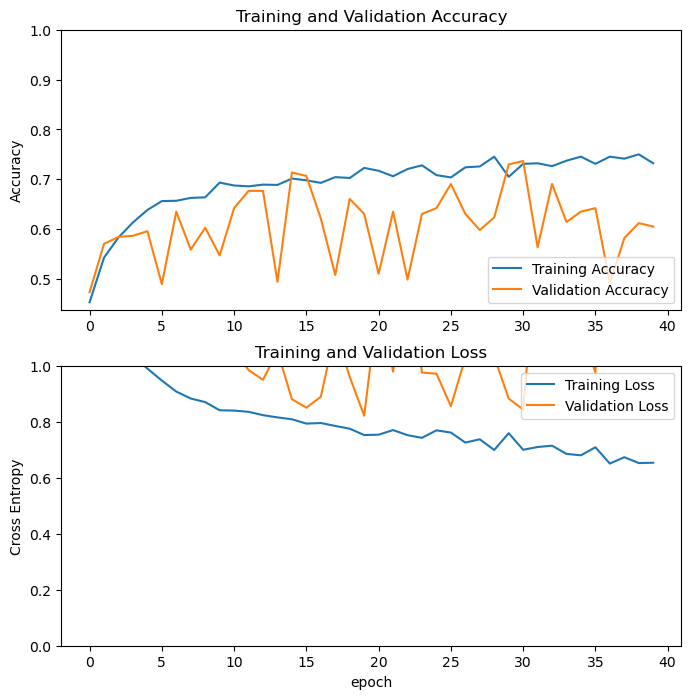

In [106]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

RNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
RNNs_model.summary()
len(RNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                28160     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_20 (Dense)            (None, 5)                 325       
                                                                 
Total params: 28,741
Trainable params: 28,613
Non-trainable params: 128
_________________________________________________________________


7

In [110]:
fine_tune_epochs = 10
initial_epochs = max(history5.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = RNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping2,
                         initial_epoch=history5.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 40/110
54/54 [==============================] - 10s 178ms/step - loss: 0.6110 - accuracy: 0.7679 - val_loss: 0.5320 - val_accuracy: 0.7968
Epoch 41/110
54/54 [==============================] - 10s 181ms/step - loss: 0.5958 - accuracy: 0.7772 - val_loss: 0.5215 - val_accuracy: 0.7898
Epoch 42/110
54/54 [==============================] - 10s 177ms/step - loss: 0.5904 - accuracy: 0.7795 - val_loss: 0.5197 - val_accuracy: 0.7852
Epoch 43/110
54/54 [==============================] - 10s 176ms/step - loss: 0.5668 - accuracy: 0.7865 - val_loss: 0.5163 - val_accuracy: 0.7898
Epoch 44/110
54/54 [==============================] - 9s 176ms/step - loss: 0.5699 - accuracy: 0.7865 - val_loss: 0.5181 - val_accuracy: 0.8014
Epoch 45/110
54/54 [==============================] - 9s 176ms/step - loss: 0.5815 - accuracy: 0.7830 - val_loss: 0.5170 - val_accuracy: 0.8014
Epoch 46/110
54/54 [==============================] - 9s 176ms/step - loss: 0.5671 - accuracy: 0.7824 - val_loss: 0.5143 - val_accur

In [111]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

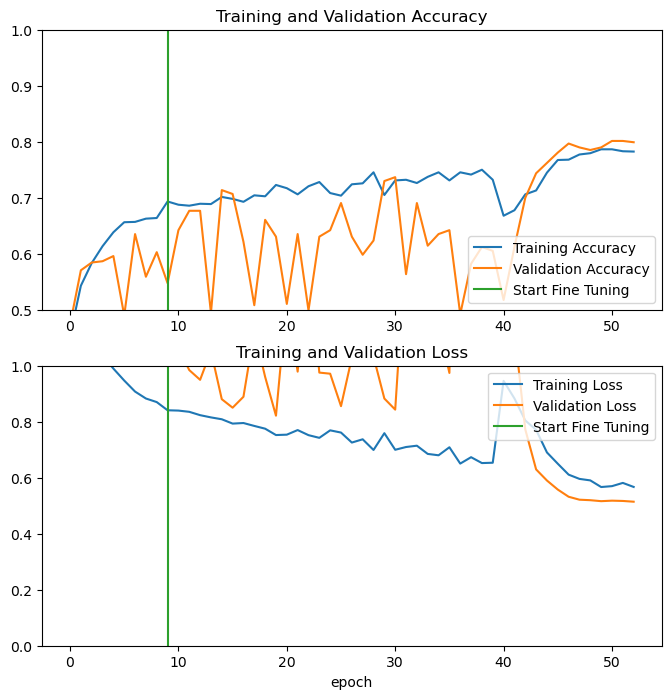

In [112]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [134]:
loss, accuracy = RNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

14/14 [==============================] - 1s 102ms/step - loss: 0.5143 - accuracy: 0.7991
Test accuracy : 0.7990761995315552


# Step 8. Decision fusion for deep learning methods

In [128]:
def normalized(data):

    normalizedData = data/np.linalg.norm(data)
    return normalizedData

In [137]:

y_pred_dl_p_2 = simple_model.predict(X_val_nn)
y_pred_cnn_p_2 = CNNs_model.predict(X_val_nn)
y_pred_rn_p_2 = model_rn.predict(X_val_nn)
y_pred_rnn_p_2 = RNNs_model.predict(X_val_nn)

14/14 [==============================] - 1s 100ms/step


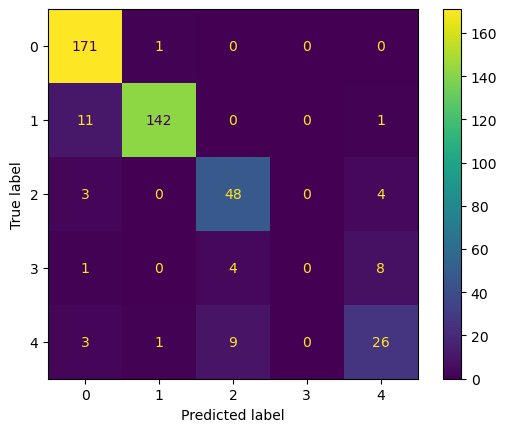

Accuracy Simple Deep Learning model:  0.8937644341801386


In [138]:

#fusion"""y_pred_dl_p_2 +
fusion_softmax = normalized(y_pred_cnn_p_2) + normalized(y_pred_rn_p_2) + normalized(y_pred_rnn_p_2)
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)

# Step 9. Test data prediction

16/16 [==============================] - 2s 105ms/step


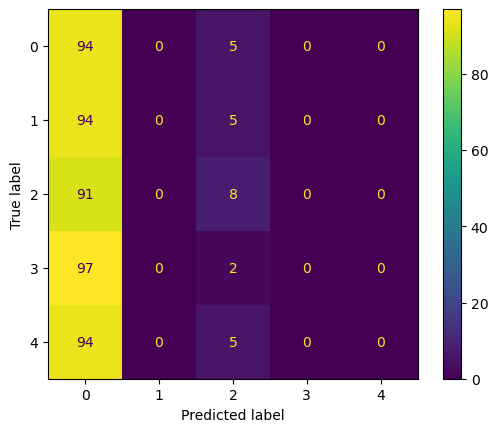

Accuracy Simple Deep Learning model:  0.20606060606060606


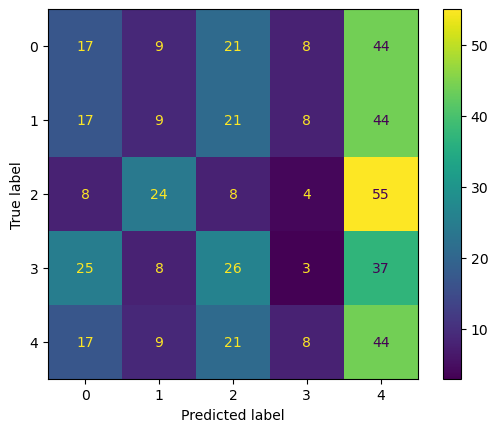

Accuracy Convolutional Neural Network model:  0.16363636363636364


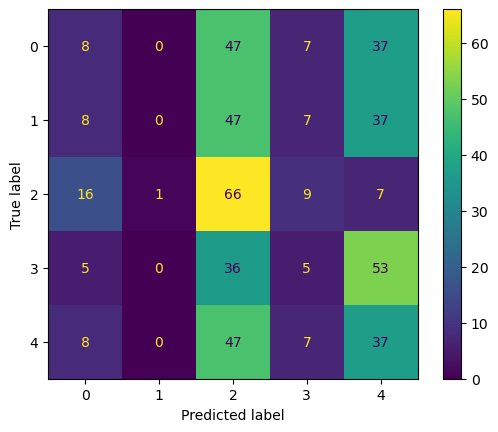

Accuracy Resnet50 model:  0.23434343434343435


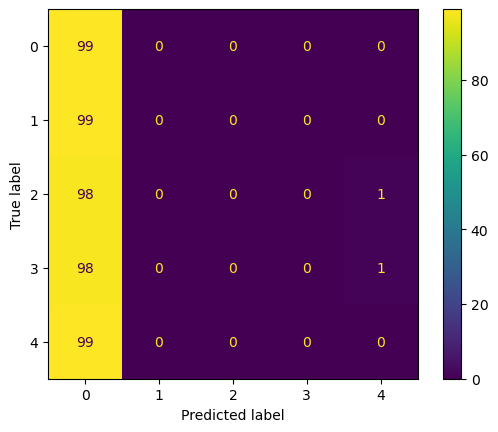

Accuracy RNN model:  0.2


In [130]:
y_pred_dl_p_3 = simple_model.predict(X_test_nn)
y_pred_cnn_p_3 = CNNs_model.predict(X_test_nn)
y_pred_rn_p_3 = model_rn.predict(X_test_nn)
y_pred_rnn_p_3 = RNNs_model.predict(X_test_nn)
y_pred_dl_3 = np.argmax(y_pred_dl_p_3,axis=1).astype(np.int16)
y_pred_cnn_3 = np.argmax(y_pred_cnn_p_3,axis=1).astype(np.int16)
y_pred_rn_3 = np.argmax(y_pred_rn_p_3,axis=1).astype(np.int16)
y_pred_rnn_3 = np.argmax(y_pred_rnn_p_3,axis=1).astype(np.int16)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_dl_3)
plt.show()
acc_dl_3 = accuracy_score(Y_test, y_pred_dl_3)
print("Accuracy Simple Deep Learning model: ", acc_dl_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_cnn_3)
plt.show()
acc_cnn_3 = accuracy_score(Y_test, y_pred_cnn_3)
print("Accuracy Convolutional Neural Network model: ", acc_cnn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rn_3)
plt.show()
acc_rn_3 = accuracy_score(Y_test, y_pred_rn_3)
print("Accuracy Resnet50 model: ", acc_rn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rnn_3)
plt.show()
acc_rnn_3 = accuracy_score(Y_test, y_pred_rnn_3)
print("Accuracy RNN model: ", acc_rnn_3)

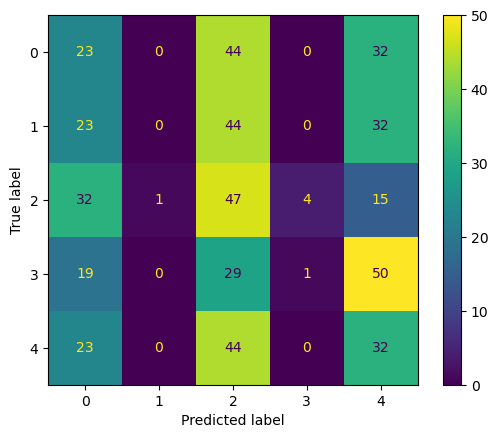

Accuracy Simple Deep Learning model:  0.2080808080808081


In [131]:
#fusion"""y_pred_dl_p_2 +
fusion_softmax_t = normalized(y_pred_cnn_p_3)  + normalized(y_pred_rn_p_3) + normalized(y_pred_rnn_p_3)
fusion_label_t = np.argmax(fusion_softmax_t,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_test, fusion_label_t)
plt.show()

acc_dl = accuracy_score(Y_test, fusion_label_t)
print("Accuracy Simple Deep Learning model: ", acc_dl)